In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Garbage_Classification_Project'
%ls

/content/drive/MyDrive/Garbage_Classification_Project
 conf_matrix_vgg_fine_tuning.jpg    history_vgg.jpg
 conf_matrix_vgg.jpg                naive_lda.pkl
'Garbage classification'/           naive.pkl
 garbage_classification_CNN.ipynb   svm_lda.pkl
 garbage_classification.ipynb       svm_ovr_lda.pkl
 garbage.jpg                        svm_ovr.pkl
 history_resnet_fine_tuning.jpg     svm.pkl
 history_resnet.jpg                 vgg19.h5
 history_vggfinetuning.jpg


# Project Code

In [3]:
!pip install pillow
!pip install termcolor
!pip install tqdm
!pip install joblib
!pip install tensorflow

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from glob import glob
import os
import tensorflow as tf
from tensorflow import keras
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Add our data-augmentation parameters to ImageDataGenerator
# The ImageDataGenerator function avoid to augment and transform 
# our images manually

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

In [5]:
def load_data(df):
    '''
        @params df: DataFrame in which we have the image file name and the label associated with it
    '''
    X = []
    y = []
    for index, row in tqdm(df.iterrows()):
        image_file = row['file']
        image_path = glob(IMG_FOLDER + "/**/" + image_file, recursive = True)
        image = plt.imread(image_path[0])
        X.append(image)
        y.append(row['class'])
    return np.array(X), np.array(y)

# Categories
- Glass (0)
- Paper (1)
- CardBoard (2)
- Plastic (3)
- Metal (4)
- Trash (5)

# Read And Anlyze the Data

In [6]:
# Data analysis
DATA_FOLDER = 'Garbage classification'
IMG_FOLDER = os.path.join(DATA_FOLDER, 'Garbage classification')

df = pd.read_csv(os.path.join(DATA_FOLDER, "labeled_images_from_zero.txt"), sep=" ", names=["file","class"])

print("Dataset")
print(df.info(verbose=True))
print(df.head())
print()

# Load the dataset
print("[INFO] Loading dataset...")
X, y = load_data(df)

Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    2527 non-null   object
 1   class   2527 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.6+ KB
None
         file  class
0  glass1.jpg      0
1  glass2.jpg      0
2  glass3.jpg      0
3  glass4.jpg      0
4  glass5.jpg      0

[INFO] Loading dataset...


2527it [09:05,  4.64it/s]


In [7]:
print(X.shape)
print(y.shape)

(2527, 384, 512, 3)
(2527,)


In [8]:
X_copy = np.copy(X)
y_copy = np.copy(y)

## Resize Images

In [9]:
X_resized = []
for array in X_copy:
    img = Image.fromarray(array)
    img = img.resize(size=(224, 224))
    img = np.array(img)
    X_resized.append(img)

X_resized = np.array(X_resized)
print(X_resized.shape)

(2527, 224, 224, 3)


In [11]:
print(y_copy[0])
y_copy = to_categorical(y_copy, num_classes=6)
print(y_copy[0])

0
[1. 0. 0. 0. 0. 0.]


## Image Augmentation

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range = 40, 
    width_shift_range = 0.4, 
    height_shift_range = 0.4,  
    zoom_range = 0.4,
    brightness_range = [0.5, 1.5],
    horizontal_flip = True,
    vertical_flip=True
)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resized, y_copy, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1895, 224, 224, 3)
(1895, 6)


## VGG19



In [16]:
X_train_vgg = keras.applications.vgg19.preprocess_input(X_train)
X_test_vgg = keras.applications.vgg19.preprocess_input(X_test)
print(X_train_vgg.shape)
print(X_test_vgg.shape)
print(np.min(X_train_vgg), np.max(X_train_vgg))

(1895, 224, 224, 3)
(632, 224, 224, 3)
-123.68 151.061


In [17]:
X_train_vgg, X_val_vgg, y_train_vgg, y_val_vgg = train_test_split(X_train_vgg, y_train, test_size=0.25, random_state=42)
print(X_train_vgg.shape)
print(X_val_vgg.shape)
print(y_train_vgg.shape)
print(y_val_vgg.shape)


(1421, 224, 224, 3)
(474, 224, 224, 3)
(1421, 6)
(474, 6)


In [18]:
base_model = keras.applications.VGG19(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(rate=0.3)(avg)
output = keras.layers.Dense(6, activation='softmax')(dropout)
model = keras.Model(inputs=base_model.input, outputs=output)
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "vgg19.h5",
    save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  min_delta=0.01,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  restore_best_weights=True)

history = model.fit(
    train_datagen.flow(X_train_vgg, y_train_vgg),
    validation_data = (X_val_vgg, y_val_vgg),
    epochs=50,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

model = keras.models.load_model("vgg19.h5") # roll back to best model

Epoch 1/50
45/45 [==============================] - 74s 863ms/step - loss: 4.0491 - accuracy: 0.2632 - val_loss: 2.0839 - val_accuracy: 0.4409
Epoch 2/50
45/45 [==============================] - 27s 594ms/step - loss: 2.6160 - accuracy: 0.4166 - val_loss: 1.6172 - val_accuracy: 0.5485
Epoch 3/50
45/45 [==============================] - 27s 603ms/step - loss: 2.1794 - accuracy: 0.4736 - val_loss: 1.2521 - val_accuracy: 0.6266
Epoch 4/50
45/45 [==============================] - 27s 604ms/step - loss: 1.8342 - accuracy: 0.5264 - val_loss: 1.1590 - val_accuracy: 0.6477
Epoch 5/50
45/45 [==============================] - 28s 612ms/step - loss: 1.6185 - accuracy: 0.5489 - val_loss: 0.9744 - val_accuracy: 0.6983
Epoch 6/50
45/45 [==============================] - 27s 592ms/step - loss: 1.3889 - accuracy: 0.6024 - val_loss: 1.0169 - val_accuracy: 0.7131
Epoch 7/50
45/45 [==============================] - 26s 586ms/step - loss: 1.3834 - accuracy: 0.6080 - val_loss: 0.9607 - val_accuracy: 0.7110

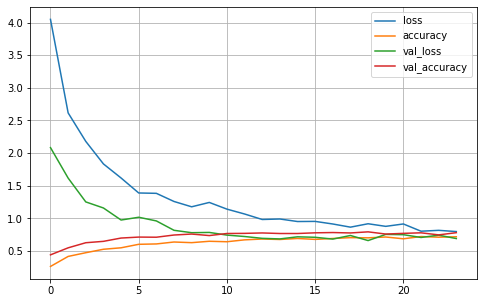

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.savefig('history_vgg.jpg')

plt.show()

In [22]:
y_proba = model.predict(X_test_vgg)
y_pred = np.argmax(y_proba, axis=1)

In [23]:
y_true = np.argmax(y_test, axis=1)

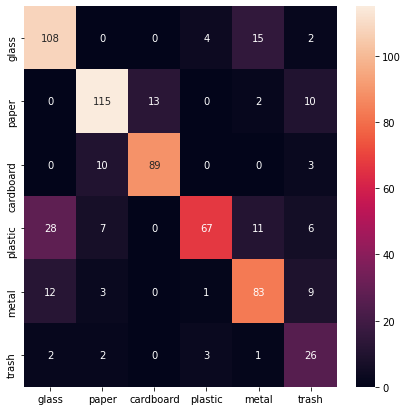

              precision    recall  f1-score   support

           0       0.72      0.84      0.77       129
           1       0.84      0.82      0.83       140
           2       0.87      0.87      0.87       102
           3       0.89      0.56      0.69       119
           4       0.74      0.77      0.75       108
           5       0.46      0.76      0.58        34

    accuracy                           0.77       632
   macro avg       0.76      0.77      0.75       632
weighted avg       0.79      0.77      0.77       632



In [25]:
import seaborn as sn
labels = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (7,7))
sn.heatmap(conf_mat, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.savefig('conf_matrix_vgg.jpg')

plt.show()

print(classification_report(y_true, y_pred))

## ResNet50


In [32]:
# preprocess all the images
X_train_res = keras.applications.resnet50.preprocess_input(X_train)
X_test_res = keras.applications.resnet50.preprocess_input(X_test)
print(np.min(X_train_res), np.max(X_train_res))

-123.68 151.061


In [33]:
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_train_res, y_train, test_size=0.25, random_state=42)
print(X_train_res.shape)
print(X_val_res.shape)
print(y_train_res.shape)
print(y_val_res.shape)

(1421, 224, 224, 3)
(474, 224, 224, 3)
(1421, 6)
(474, 6)


In [34]:
base_model = keras.applications.ResNet50(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(rate=0.3)(avg)
output = keras.layers.Dense(6, activation='softmax')(dropout)
model = keras.Model(inputs=base_model.input, outputs=output)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________

In [35]:
for layer in base_model.layers:
    layer.trainable = False

In [36]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "resnet50.h5",
    save_best_only=True
)

history = model.fit(
    train_datagen.flow(X_train_res, y_train_res),
    validation_data = (X_val_res, y_val_res),
    epochs=50,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

model = keras.models.load_model("resnet50.h5") # roll back to best model

Epoch 1/50
45/45 [==============================] - 33s 623ms/step - loss: 1.3694 - accuracy: 0.4856 - val_loss: 0.6974 - val_accuracy: 0.7447


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
45/45 [==============================] - 26s 568ms/step - loss: 0.9330 - accuracy: 0.6636 - val_loss: 0.6469 - val_accuracy: 0.7595
Epoch 3/50
45/45 [==============================] - 26s 574ms/step - loss: 0.8688 - accuracy: 0.6777 - val_loss: 0.6187 - val_accuracy: 0.7806
Epoch 4/50
45/45 [==============================] - 26s 570ms/step - loss: 0.7672 - accuracy: 0.7122 - val_loss: 0.5407 - val_accuracy: 0.8101
Epoch 5/50
45/45 [==============================] - 25s 562ms/step - loss: 0.7312 - accuracy: 0.7368 - val_loss: 0.5370 - val_accuracy: 0.8017
Epoch 6/50
45/45 [==============================] - 26s 567ms/step - loss: 0.6961 - accuracy: 0.7375 - val_loss: 0.6074 - val_accuracy: 0.8017
Epoch 7/50
45/45 [==============================] - 26s 566ms/step - loss: 0.6945 - accuracy: 0.7516 - val_loss: 0.5187 - val_accuracy: 0.8186
Epoch 8/50
45/45 [==============================] - 26s 569ms/step - loss: 0.6122 - accuracy: 0.7685 - val_loss: 0.5105 - val_accuracy: 0.8143

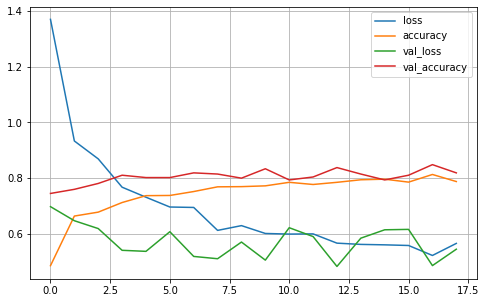

In [37]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.savefig('history_resnet.jpg')

plt.show()

In [38]:
y_proba = model.predict(X_test_res)
y_pred = np.argmax(y_proba, axis=1)

In [39]:
y_true = np.argmax(y_test, axis=1)

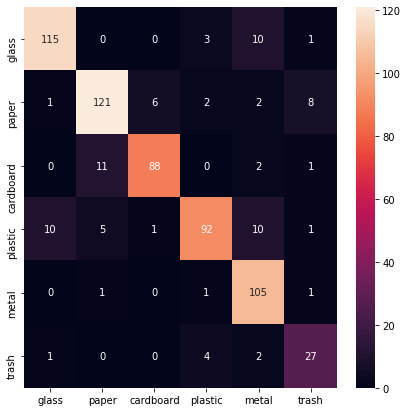

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       129
           1       0.88      0.86      0.87       140
           2       0.93      0.86      0.89       102
           3       0.90      0.77      0.83       119
           4       0.80      0.97      0.88       108
           5       0.69      0.79      0.74        34

    accuracy                           0.87       632
   macro avg       0.85      0.86      0.85       632
weighted avg       0.87      0.87      0.87       632



In [41]:
labels = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat = pd.DataFrame(conf_mat)
plt.figure(figsize = (7,7))
sn.heatmap(conf_mat, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.savefig('conf_matrix_resnet.jpg')
plt.show()

print(classification_report(y_true, y_pred))

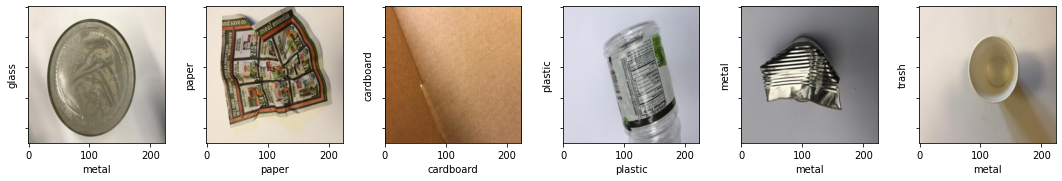

In [48]:
fig, axs = plt.subplots(1, 6, figsize=(15,15))
fig.tight_layout()
for label in range(len(labels)):
  items = X_test[np.argmax(y_test, axis=1) == label]
  pred = y_pred[np.argmax(y_test, axis=1) == label]
  axs[label].imshow(items[0])
  axs[label].set_ylabel(labels[label])
  axs[label].set_yticklabels([])
  axs[label].set_xlabel(labels[pred[0]])

plt.savefig('garbage.jpg')
plt.show()